### Dataset

In [1]:
!pip install ucimlrepo

#### the libraries

In [169]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import adjusted_rand_score, silhouette_score
import warnings

## **Data Preprocessing & Cleaning**

In [113]:
heart_disease = fetch_ucirepo(id=45)
input = heart_disease.data.features
target = heart_disease.data.targets
C1= ['cp',  'restecg', 'slope', 'ca', 'thal']
C2=['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X_clean = input.copy()
invalid_zero_cols = ['trestbps', 'chol', 'thalach', 'oldpeak']

for col in invalid_zero_cols:
    X_clean.loc[X_clean[col] == 0, col] = np.nan


X_clean = X_clean.fillna(X_clean.median(numeric_only=True))
in_encoded = pd.get_dummies(X_clean, columns=C1,prefix=C1 , drop_first=True)
scaler = StandardScaler()
in_scaled = scaler.fit_transform(in_encoded)
in_scaled = pd.DataFrame(in_scaled, columns=in_encoded.columns,index=in_encoded.index)
print(in_scaled.shape)


(303, 20)


### viusalization

<Figure size 1200x800 with 0 Axes>

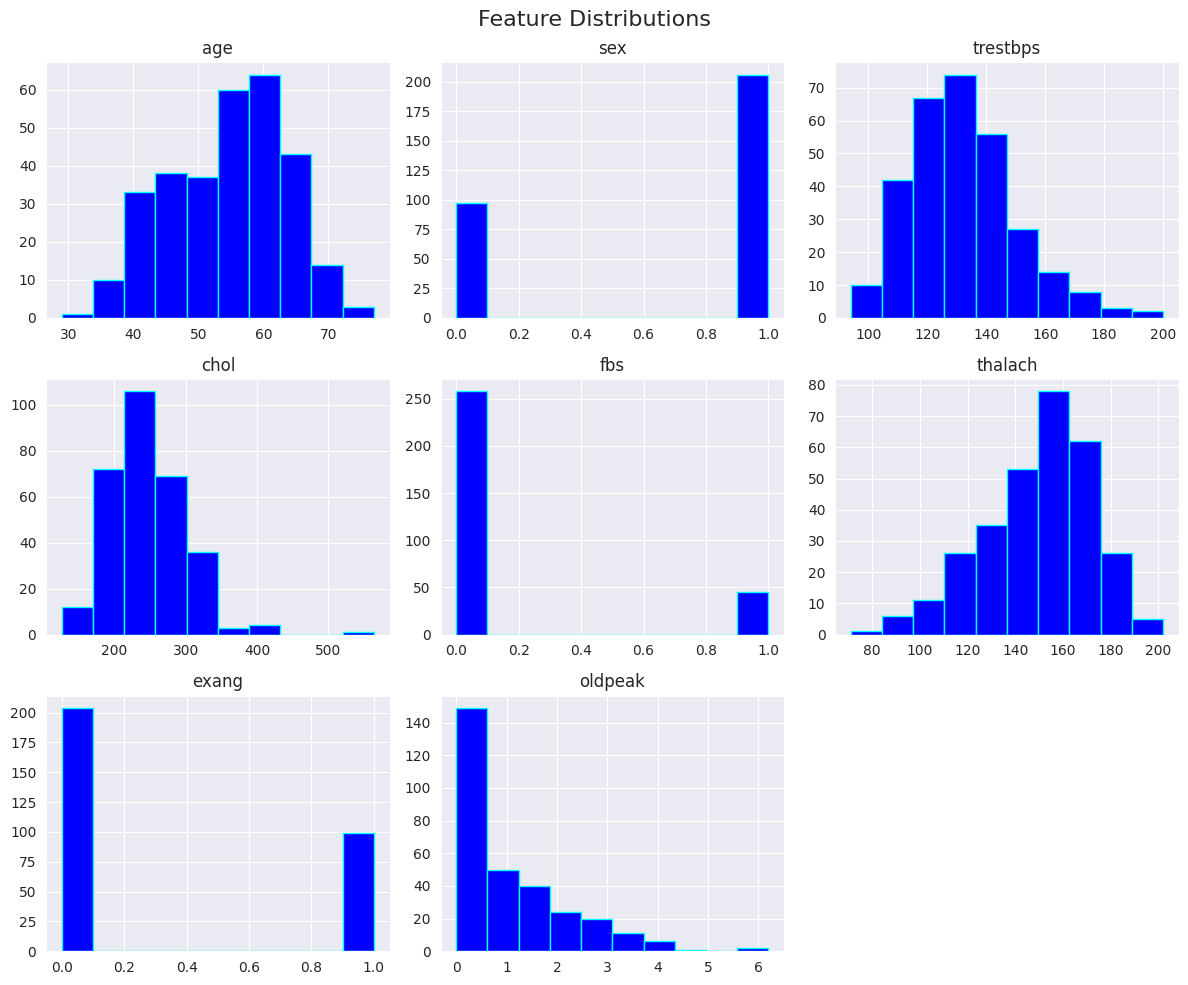

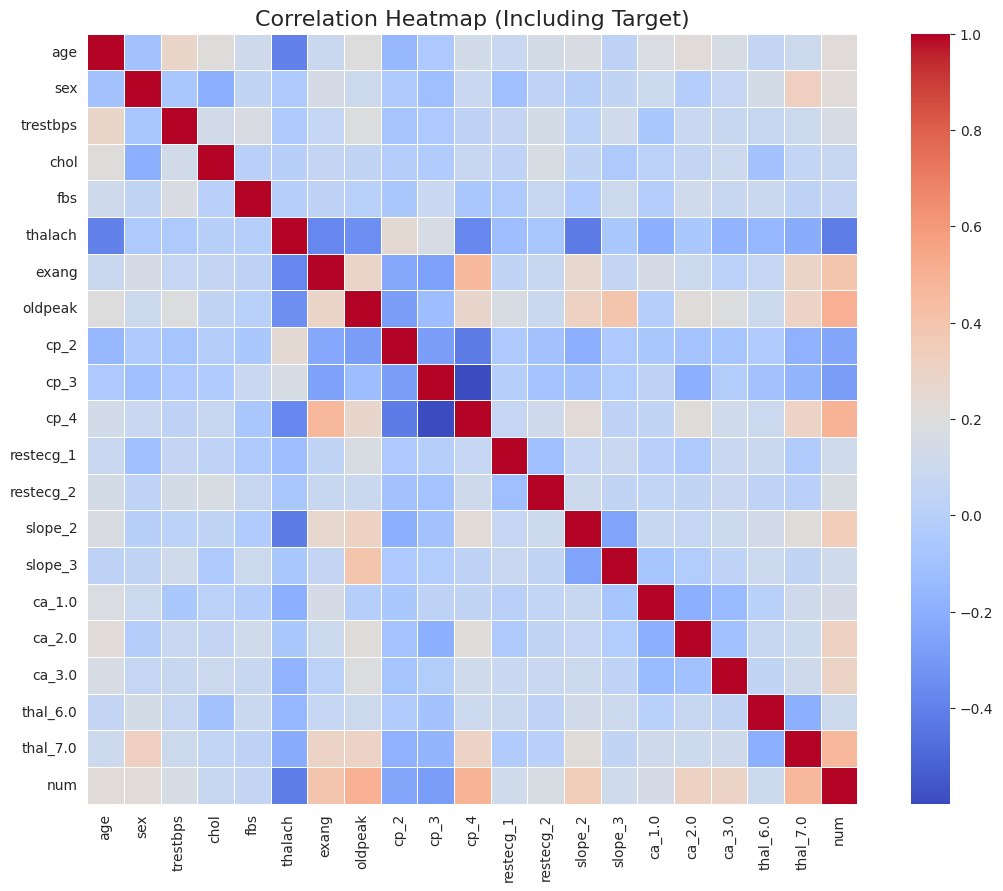

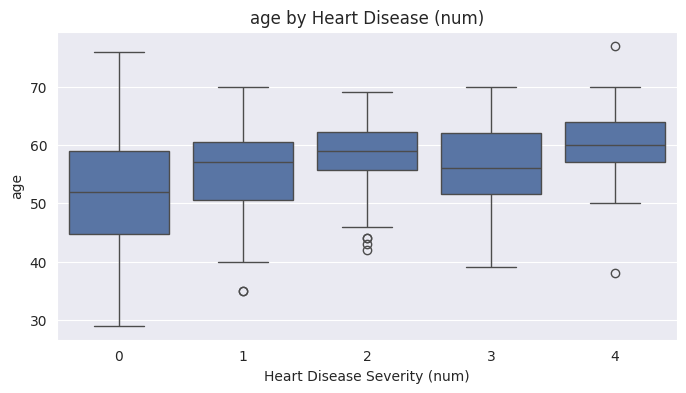

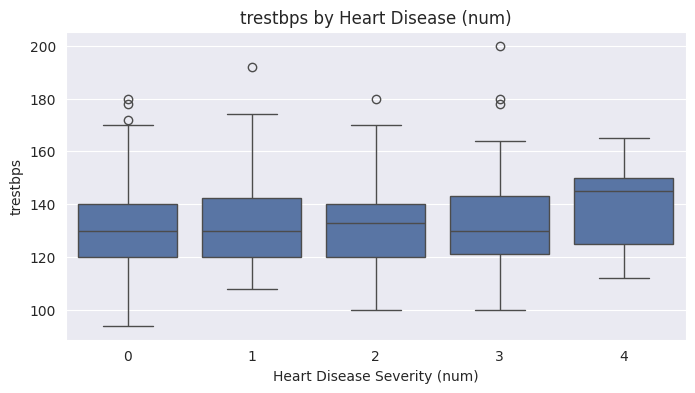

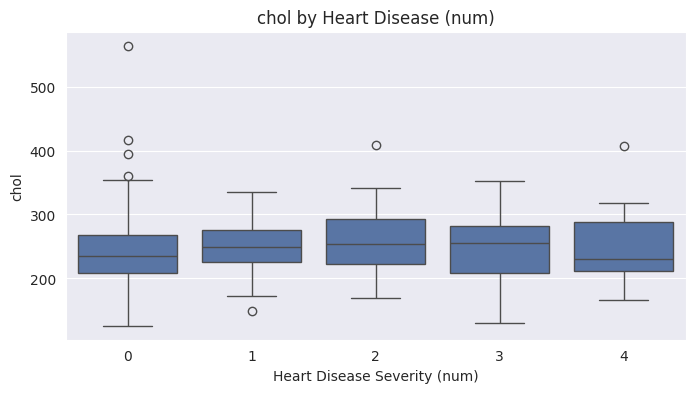

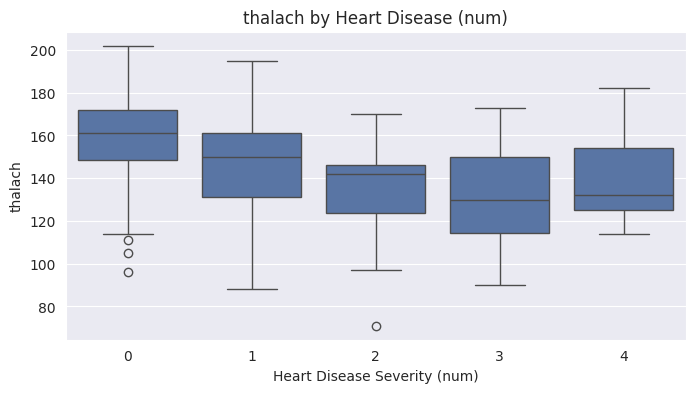

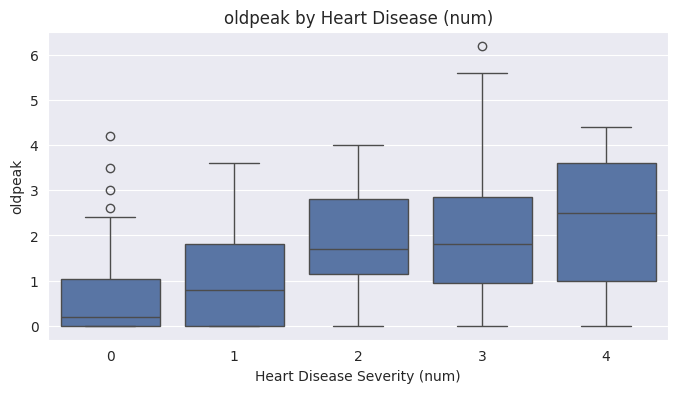

In [103]:
# histogram
plt.figure(figsize=(12, 8))
in_encoded.hist( figsize=(12, 10), color='blue', edgecolor='cyan')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()
conct_plot = pd.concat([in_encoded, target], axis=1)
copy_cont = conct_plot.copy()
corr = conct_plot.corr()
# heat map
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', square=True, linewidths=.5)
plt.title("Correlation Heatmap (Including Target)", fontsize=16)
plt.show()
# boxplots
for col in C2:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='num', y=col, data=copy_cont)
    plt.title(f'{col} by Heart Disease (num)')
    plt.xlabel('Heart Disease Severity (num)')
    plt.ylabel(col)
    plt.show()

### 2.2 Dimensionality Reduction - PCA (Principal Component Analysis)


In [114]:
# I tried the n_compnents my self unitll I found the variance >= 80% at 12
pca = PCA(n_components=12)
d_pca = pca.fit_transform(in_scaled)

d_pca_df = pd.DataFrame(
    d_pca,
    columns=[f'PC{i+1}' for i in range(12)],
    index=in_encoded.index
)
print("Shape of d_pca:", d_pca_df.shape)

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by 2 components: {explained_variance}")
print(f"Total explained variance: {sum(explained_variance):.2f}")

Shape of d_pca: (303, 12)
Explained variance by 2 components: [0.15835668 0.08468399 0.0794662  0.07149997 0.06602022 0.06209598
 0.0574518  0.05515077 0.05084424 0.04240728 0.04111947 0.03852477]
Total explained variance: 0.81


### Visuals Scatter PCA and plot of the accumulative

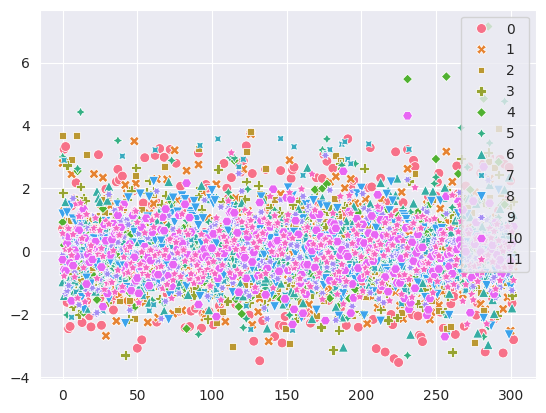

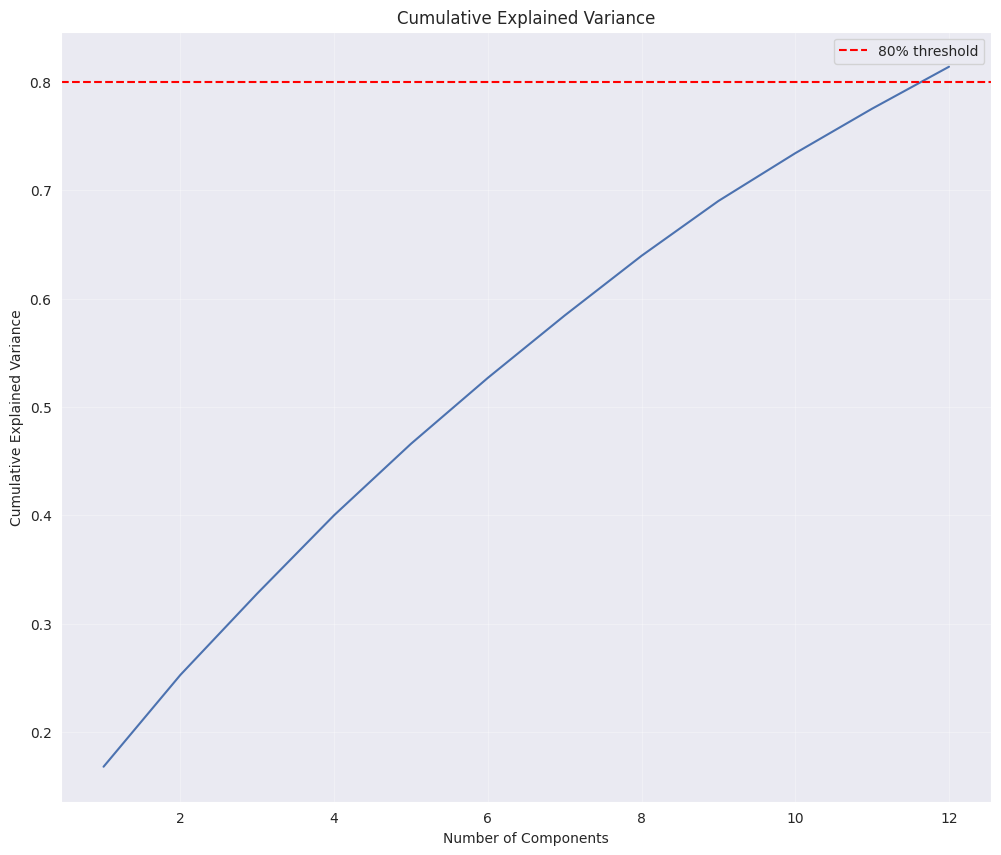

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

In [105]:
sns.scatterplot(data=d_pca,s=50)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 10))
plt.plot(range(1, len(cumsum) + 1), cumsum)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
plt.figure(figsize=(12, 10))

### Feature Selection


In [127]:
t1 = target.values.ravel()
model = RandomForestRegressor(random_state=42)
model.fit(d_pca_df, target)

feature_importances = pd.Series(model.feature_importances_, index=d_pca_df.columns)
feature_importances = feature_importances.sort_values(ascending=False)
model_rfe = RandomForestClassifier(n_estimators=50, random_state=42)
X_final = in_scaled.copy()

n_features_to_select = 10
rfe = RFE(estimator=model_rfe, n_features_to_select=n_features_to_select)
rfe.fit(X_final, t1)
selected_features_rfe = X_final.columns[rfe.support_].tolist()
print("✅ Top 10 Features Selected by RFE:")
for i, feat in enumerate(selected_features_rfe, 1):
    print(f"   {i}. {feat}")

feature_ranking = pd.DataFrame({
    'Feature': X_final.columns,
    'Selected': rfe.support_,
    'Rank': rfe.ranking_
}).sort_values('Rank')

print("\n📊 Full Feature Ranking (Lowest Rank = Most Important):")
print(feature_ranking)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✅ Top 10 Features Selected by RFE:
   1. age
   2. trestbps
   3. chol
   4. thalach
   5. exang
   6. oldpeak
   7. cp_4
   8. slope_2
   9. ca_1.0
   10. thal_7.0

📊 Full Feature Ranking (Lowest Rank = Most Important):
      Feature  Selected  Rank
0         age      True     1
2    trestbps      True     1
3        chol      True     1
5     thalach      True     1
7     oldpeak      True     1
6       exang      True     1
13    slope_2      True     1
10       cp_4      True     1
15     ca_1.0      True     1
19   thal_7.0      True     1
1         sex     False     2
16     ca_2.0     False     3
12  restecg_2     False     4
17     ca_3.0     False     5
4         fbs     False     6
9        cp_3     False     7
18   thal_6.0     False     8
14    slope_3     False     9
8        cp_2     False    10
11  restecg_1     False    11


In [128]:
scaler_chi2 = MinMaxScaler()
X_chi2 = scaler_chi2.fit_transform(X_final)


X_chi2 = np.clip(X_chi2, 0, None)

chi2_stats, p_values = chi2(X_chi2, t1)

chi2_results = pd.DataFrame({
    'Feature': X_final.columns,
    'Chi2_Stat': chi2_stats,
    'P_Value': p_values
}).sort_values('Chi2_Stat', ascending=False)

print("✅ Chi-Square Test Results (Most Significant First):")
print(chi2_results)

significant_features = chi2_results[chi2_results['P_Value'] < 0.05]
print(f"\n🎯 Number of statistically significant features (p < 0.05): {len(significant_features)}")
print("Top 5 significant features:")
print(significant_features.head(5)[['Feature', 'Chi2_Stat', 'P_Value']])

✅ Chi-Square Test Results (Most Significant First):
      Feature  Chi2_Stat       P_Value
19   thal_7.0  46.721875  1.742480e-09
10       cp_4  45.129615  3.736737e-09
6       exang  41.534482  2.083076e-08
16     ca_2.0  34.648382  5.485601e-07
17     ca_3.0  29.999871  4.894734e-06
13    slope_2  22.408432  1.661808e-04
9        cp_3  21.974965  2.027333e-04
8        cp_2  16.942450  1.983352e-03
15     ca_1.0  15.262296  4.187001e-03
18   thal_6.0  10.943440  2.720708e-02
1         sex   7.499223  1.117436e-01
4         fbs   6.658223  1.550901e-01
11  restecg_1   6.557266  1.612178e-01
12  restecg_2   6.458947  1.673955e-01
14    slope_3   5.528483  2.372371e-01
7     oldpeak   5.475394  2.419009e-01
5     thalach   3.133976  5.356604e-01
0         age   1.244886  8.706545e-01
2    trestbps   0.622014  9.605862e-01
3        chol   0.175931  9.963506e-01

🎯 Number of statistically significant features (p < 0.05): 10
Top 5 significant features:
     Feature  Chi2_Stat       P_Value


In [206]:

scaler = MinMaxScaler()

X_final = X_final[selected_features_rfe]

y_binary = (t1> 0).astype(int)
print(y_binary.ndim)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)
print(y_train.shape)
print(y_test.shape)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}


trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

1
(242,)
(61,)


In [207]:

results = []

plt.figure(figsize=(8, 6))

for name, model in trained_models.items():

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    y_prob_positive = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(
        y_test,
        y_prob_positive,
        multi_class='ovr',
        average='macro'
    )

    results.append([name, acc, prec, rec, f1, auc_score])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"])
print("📊 Model Comparison (Multi-Class):")
print(results_df.round(3))


📊 Model Comparison (Multi-Class):
                 Model  Accuracy  Precision  Recall     F1    AUC
0  Logistic Regression     0.885      0.884   0.886  0.885  0.953
1        Decision Tree     0.770      0.773   0.774  0.770  0.774
2        Random Forest     0.869      0.868   0.871  0.869  0.938
3                  SVM     0.902      0.904   0.898  0.900  0.955


<Figure size 800x600 with 0 Axes>

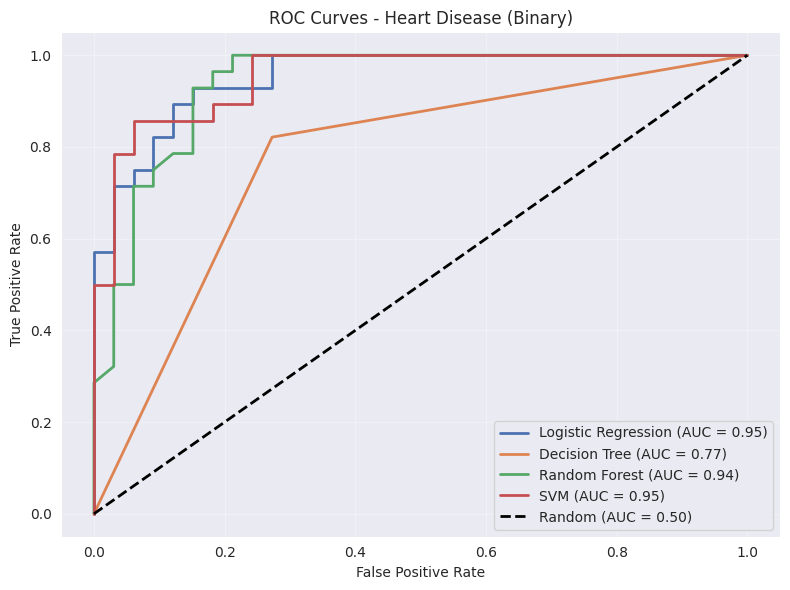

In [235]:

plt.figure(figsize=(8, 6))

for name, model in trained_models.items():
    # Get probability for positive class (class 1)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)  # ✅ Binary: no multi_class

    # Plot
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

# Random line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC = 0.50)')

# Labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Heart Disease (Binary)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

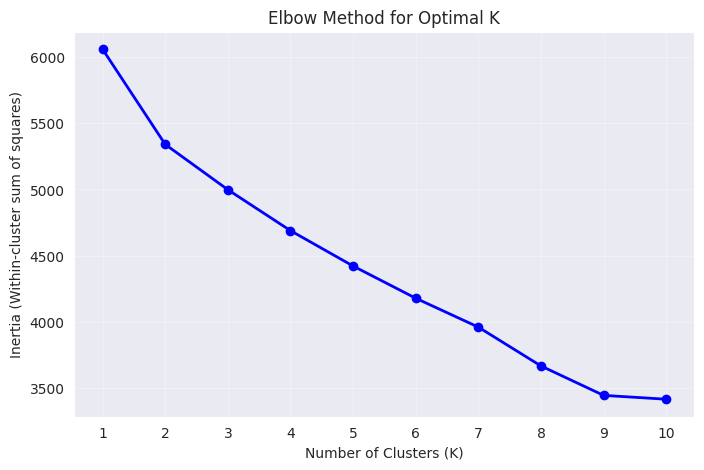

In [236]:
# Elbow method to find optimal K
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_final)
    inertias.append(kmeans.inertia_)

# Plot elbow
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=6)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.show()

In [247]:
# Assume elbow suggests K=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(in_scaled)

# Add cluster labels
X_clustered = X_final.copy()
X_clustered['Cluster'] = cluster_labels

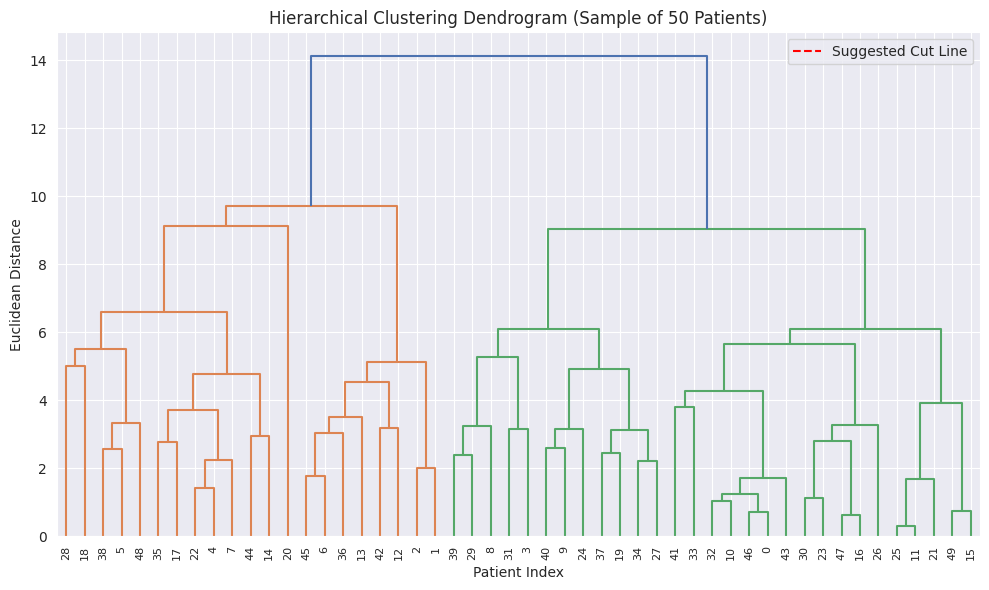

In [248]:

# Linkage
linked = linkage(in_scaled.sample(50, random_state=42), method='ward')  # Sample to speed up

# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked,
           labels=None,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram (Sample of 50 Patients)')
plt.xlabel('Patient Index')
plt.ylabel('Euclidean Distance')
plt.axhline(y=15, color='r', linestyle='--', label='Suggested Cut Line')
plt.legend()
plt.tight_layout()
plt.show()

In [249]:


comparison = pd.crosstab(
    pd.Series(cluster_labels, name='Cluster'),
    pd.Series(y_binary, name='Heart Disease'),
    margins=True
)
print("📊 Cluster vs Actual Disease (Contingency Table):")
print(comparison)

📊 Cluster vs Actual Disease (Contingency Table):
Heart Disease    0    1  All
Cluster                     
0               23  100  123
1              141   39  180
All            164  139  303


In [250]:

ari = adjusted_rand_score(y_binary, cluster_labels)
print(f"\n🎯 Adjusted Rand Index (vs true labels): {ari:.3f}")



🎯 Adjusted Rand Index (vs true labels): 0.347
